This code is heavily inspired from [Sebastian Raschka](https://x.com/rasbt)'s excellent book, "[Build a Large Language Model (From Scratch)](https://www.manning.com/books/build-a-large-language-model-from-scratch)".

I highly recommend buying and reading that book.

My code here is taken directly from Sebastian's book, but with some slight variable and styling updates.

Questions?  Feel free to DM me on [Twitter](https://x.com/virattt).

In [1]:
!pip install tiktoken --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 6.6 MB/s eta 0:00:00


### 1. Setup the config

In [2]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 1024,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False
}

### 2. Implement "dummy" transformer

In [3]:
import torch
import torch.nn as nn

class DummyGPTModel(nn.Module):
  def __init__(self, config):
    super().__init__()

    self.token_embedding = nn.Embedding(config["vocab_size"], config["emb_dim"])          # 50257 x 768
    self.position_embedding = nn.Embedding(config["context_length"], config["emb_dim"])   # 1024 x 768
    self.drop_embedding = nn.Dropout(config["drop_rate"])
    self.transformer_blocks = nn.Sequential(
        *[DummyTransformerBlock(config)
          for _ in range(config["n_layers"])]
    )
    self.layer_norm = DummyLayerNorm(config["emb_dim"])
    self.out_head = nn.Linear(
        config["emb_dim"], config["vocab_size"], bias=False
    )

  def forward(self, in_idx):
    batch_size, sequence_length = in_idx.shape
    token_embeddings = self.token_embedding(in_idx)
    position_embeddings = self.position_embedding(
      torch.arange(sequence_length, device=in_idx.device)
    )
    x = token_embeddings + position_embeddings
    x = self.drop_embedding(x)
    x = self.transformer_blocks(x)
    x = self.layer_norm(x)
    logits = self.out_head(x)
    return logits


class DummyTransformerBlock(nn.Module):
  def __init__(self, config):
      super().__init__()

  def forward(self, x):
    return x

class DummyLayerNorm(nn.Module):
  def __init__(self, emb_dim):
    super().__init__()

  def forward(self, x):
    return x

### 3. Test out "dummy" transformer

In [4]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [5]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch)
print(f"Output shape: {logits.shape}")
print(logits)

Output shape: torch.Size([2, 4, 50257])
tensor([[[-0.9289,  0.2748, -0.7557,  ..., -1.6070,  0.2702, -0.5888],
         [-0.4476,  0.1726,  0.5354,  ..., -0.3932,  1.5285,  0.8557],
         [ 0.5680,  1.6053, -0.2155,  ...,  1.1624,  0.1380,  0.7425],
         [ 0.0447,  2.4787, -0.8843,  ...,  1.3219, -0.0864, -0.5856]],

        [[-1.5474, -0.0542, -1.0571,  ..., -1.8061, -0.4494, -0.6747],
         [-0.8422,  0.8243, -0.1098,  ..., -0.1434,  0.2079,  1.2046],
         [ 0.1355,  1.1858, -0.1453,  ...,  0.0869, -0.1590,  0.1552],
         [ 0.1666, -0.8138,  0.2307,  ...,  2.5035, -0.3055, -0.3083]]],
       grad_fn=<UnsafeViewBackward0>)


### 4. Normalize the vector activations

In [6]:
torch.manual_seed(123)
batch_example = torch.randn(2, 5)
layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_example)
print(out)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


In [7]:
# Examine mean and variance
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)
print(f"Mean: {mean} \n")
print(f"Variance: {var} \n")

Mean: tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>) 

Variance: tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>) 



In [8]:
out_norm = (out - mean) / torch.sqrt(var) # This is also known as the standard deviation
mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)
print("Normalized layer outputs:\n", out_norm)
print("Mean:\n", mean)
print("Variance:\n", var)

Normalized layer outputs:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean:
 tensor([[9.9341e-09],
        [1.9868e-08]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [9]:
class LayerNorm(nn.Module):
  def __init__(self, emb_dim):
    super().__init__()
    self.eps = 1e-5
    self.scale = nn.Parameter(torch.ones(emb_dim))
    self.shift = nn.Parameter(torch.zeros(emb_dim))

  def forward(self, x):
    mean = x.mean(dim=-1, keepdim=True)
    var = x.var(dim=-1, keepdim=True, unbiased=False)
    normalized_x = (x - mean) / torch.sqrt(var + self.eps)
    return self.scale * normalized_x + self.shift

In [10]:
# Try out the LayerNorm module
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, keepdim=True, unbiased=False)
print(f"Mean: {mean} \n")
print(f"Variance: {var} \n")

Mean: tensor([[-2.9802e-08],
        [ 0.0000e+00]], grad_fn=<MeanBackward1>) 

Variance: tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>) 



### 5. Implement feed forward network with GELU activations

In [11]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))

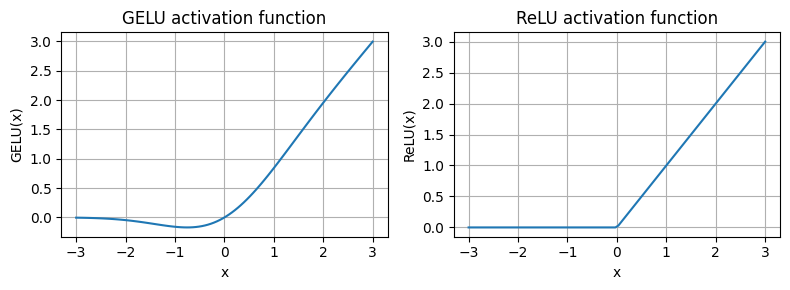

In [12]:
import matplotlib.pyplot as plt
gelu, relu = GELU(), nn.ReLU()

x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)
plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)
plt.tight_layout()
plt.show()

In [13]:
# Implement feed-forward neural network
class FeedForward(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(config["emb_dim"], 4 * config["emb_dim"]),
        GELU(),
        nn.Linear(4 * config["emb_dim"], config["emb_dim"]),
    )

  def forward(self, x):
    return self.layers(x)

In [14]:
# Test it out
ffn = FeedForward(GPT_CONFIG_124M)
x = torch.rand(2, 3, 768) # 2 batches, 3 input examples, 768 embeddings per example
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


### 6. Implement multi-head attention

In [15]:
class MultiHeadAttention(nn.Module):
  def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
    super().__init__()

    assert d_out % num_heads == 0, "d_out must be divisible by num_heads"

    self.d_out = d_out                  # 768
    self.num_heads = num_heads          # 12
    self.head_dim = d_out // num_heads  # 64
    self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
    self._out_proj = nn.Linear(d_out, d_out)
    self.dropout = nn.Dropout(dropout)
    self.register_buffer(
        'mask',
        torch.triu(torch.ones(
            context_length,             # 1024
            context_length,             # 1024
          ), diagonal=1)
    )

  def forward(self, x):
    batch_size, num_tokens, embedding_length = x.shape
    keys = self.W_key(x)
    queries = self.W_query(x)
    values = self.W_value(x)

    # Add the num_heads and head_dim dimensions
    keys = keys.view(batch_size, num_tokens, self.num_heads, self.head_dim)       # Transform to a tensor of dimensions: 2 x 1024 x 12 x 64
    queries = queries.view(batch_size, num_tokens, self.num_heads, self.head_dim) # Transform to a tensor of dimensions: 2 x 1024 x 12 x 64
    values = values.view(batch_size, num_tokens, self.num_heads, self.head_dim)   # Transform to a tensor of dimensions: 2 x 1024 x 12 x 64

    # Transpose from (batch_size, num_tokens, num_heads, head_dim) to (batch_size, num_heads, num_tokens, head_dim)
    queries = queries.transpose(1, 2)
    keys = keys.transpose(1, 2)
    values = values.transpose(1, 2)

    # Calculate attention scores
    attention_scores = queries @ keys.transpose(2, 3)
    mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

    # Mask the attention scores
    attention_scores.masked_fill_(mask_bool, -torch.inf)

    # Calculate attention weights
    attention_weights = torch.softmax(attention_scores / keys.shape[-1]**0.5, dim=-1)

    # Apply dropout to attention weights
    attention_weights = self.dropout(attention_weights)

    # Calculate context vectors
    context_vectors = (attention_weights @ values).transpose(1, 2)

    # Concatenate the context vectors
    context_vectors = context_vectors.contiguous().view(batch_size, num_tokens, self.d_out)
    return self._out_proj(context_vectors)

### 7. Implement the Transformer block

In [16]:
class TransformerBlock(nn.Module):
  def __init__(self, config):
    super().__init__()

    self.attention = MultiHeadAttention(
        d_in=config["emb_dim"],
        d_out=config["emb_dim"],
        context_length=config["context_length"],
        dropout=config["drop_rate"],
        num_heads=config["n_heads"],
        qkv_bias=config["qkv_bias"]
    )

    self.ff = FeedForward(config)
    self.norm1 = LayerNorm(config["emb_dim"])
    self.norm2 = LayerNorm(config["emb_dim"])
    self.drop_shortcut = nn.Dropout(config["drop_rate"])

  def forward(self, x):
    shortcut = x

    # Attention layer
    x = self.norm1(x)
    x = self.attention(x)
    x = self.drop_shortcut(x)
    x = x + shortcut         # Add the original input back

    # Feedforward layer
    shortcut = x
    x = self.norm2(x)
    x = self.ff(x)
    x = self.drop_shortcut(x)
    x = x + shortcut         # Add the original input back
    return x

In [17]:
# Instantiate TransformerBlock and feed it some sample data

torch.manual_seed(123)
x = torch.rand(2, 3, 768)
block = TransformerBlock(GPT_CONFIG_124M)
out = block(x)

print(f"Input shape: {x.shape}")
print(f"Output shape: {out.shape}")
print(f"Output: {out}")

Input shape: torch.Size([2, 3, 768])
Output shape: torch.Size([2, 3, 768])
Output: tensor([[[-0.1163,  1.0086,  0.8360,  ...,  1.2381,  0.4222, -0.2056],
         [ 0.1673,  0.0575,  0.2935,  ...,  0.6314,  0.1199,  0.7407],
         [ 0.6281, -0.0787,  0.6029,  ...,  1.2720,  0.2060,  0.3016]],

        [[ 0.0759,  1.2133, -0.0308,  ..., -0.4852,  0.0698,  0.8456],
         [ 0.4643,  1.0002, -0.4636,  ...,  0.0624,  0.6154,  0.3102],
         [-0.0400,  0.0747, -0.0285,  ...,  0.2449,  0.4788,  0.7857]]],
       grad_fn=<AddBackward0>)


### 8. Implement the GPT model

In [18]:
class GPTModel(nn.Module):
  def __init__(self, config):
    super().__init__()

    self.token_embedding = nn.Embedding(config["vocab_size"], config["emb_dim"])
    self.positional_embedding = nn.Embedding(config["context_length"], config["emb_dim"])
    self.drop_embedding = nn.Dropout(config["drop_rate"])

    self.transformer_blocks = nn.Sequential(
        *[TransformerBlock(config) for _ in range(config["n_layers"])]
    )

    self.final_norm = LayerNorm(config["emb_dim"])
    self.out_head = nn.Linear(config["emb_dim"], config["vocab_size"], bias=False)

  def forward(self, in_idx):
    batch_size, sequence_length = in_idx.shape
    token_embeddings = self.token_embedding(in_idx)
    positional_embeddings = self.positional_embedding(
        torch.arange(sequence_length, device=in_idx.device)
    )
    x = token_embeddings + positional_embeddings
    x = self.drop_embedding(x)

    x = self.transformer_blocks(x)
    x = self.final_norm(x)
    logits = self.out_head(x)
    return logits

In [19]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)

out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[ 0.1381,  0.0077, -0.1963,  ..., -0.0222, -0.1060,  0.1717],
         [ 0.3865, -0.8408, -0.6564,  ..., -0.5163,  0.2369, -0.3357],
         [ 0.6989, -0.1829, -0.1631,  ...,  0.1472, -0.6504, -0.0056],
         [-0.4290,  0.1669, -0.1258,  ...,  1.1579,  0.5303, -0.5549]],

        [[ 0.1094, -0.2894, -0.1467,  ..., -0.0557,  0.2911, -0.2824],
         [ 0.0882, -0.3552, -0.3527,  ...,  1.2930,  0.0053,  0.1898],
         [ 0.6091,  0.4702, -0.4094,  ...,  0.7688,  0.3787, -0.1974],
         [-0.0612, -0.0737,  0.4751,  ...,  1.2463, -0.3834,  0.0609]]],
       grad_fn=<UnsafeViewBackward0>)


### 9. Generate some text

In [20]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)

        logits = logits[:, -1, :]
        probas = torch.softmax(logits, dim=-1)
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)
        idx = torch.cat((idx, idx_next), dim=1)

    return idx

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)
    # .unsqueeze(0) adds the batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # Remove batch dimension
    return tokenizer.decode(flat.tolist())


In [21]:
import torch

GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 256,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False
}
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()

GPTModel(
  (token_embedding): Embedding(50257, 768)
  (positional_embedding): Embedding(256, 768)
  (drop_embedding): Dropout(p=0.1, inplace=False)
  (transformer_blocks): Sequential(
    (0): TransformerBlock(
      (attention): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (_out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (attention): MultiHead

In [22]:
start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


### 10. Calculate text generation loss

In [23]:
# Some sample inputs
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]

In [24]:
# Some sample targets for inputs
targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [588,  428,  11311]]) #  " really like chocolate"]

In [25]:
# Feed inputs into the model
with torch.no_grad():
  logits = model(inputs)

probas = torch.softmax(logits, dim=-1)
print(f"Probas shape: {probas.shape}")
print(f"Probas: {probas}")

Probas shape: torch.Size([2, 3, 50257])
Probas: tensor([[[1.8849e-05, 1.5172e-05, 1.1687e-05,  ..., 2.2409e-05,
          6.9776e-06, 1.8776e-05],
         [9.1569e-06, 1.0062e-05, 7.8786e-06,  ..., 2.9090e-05,
          6.0103e-06, 1.3571e-05],
         [2.9877e-05, 8.8507e-06, 1.5741e-05,  ..., 3.5456e-05,
          1.4094e-05, 1.3526e-05]],

        [[1.2561e-05, 2.0538e-05, 1.4332e-05,  ..., 1.0389e-05,
          3.4784e-05, 1.4239e-05],
         [7.2731e-06, 1.7864e-05, 1.0565e-05,  ..., 2.1206e-05,
          1.1390e-05, 1.5559e-05],
         [2.9496e-05, 3.3605e-05, 4.1029e-05,  ..., 6.5249e-06,
          5.8203e-05, 1.3698e-05]]])


In [26]:
probas[0, [0], targets[0][0]]

tensor([7.4540e-05])

In [27]:
# Get the corresponding token_ids
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print(f"Token IDs:\n {token_ids}")

Token IDs:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


In [28]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
Outputs batch 1:  Armed heNetflix


In [29]:
# Calculate the target probabilities
# The outputs (target_probas_1 and target_probas_2) show the probabilities that the model assigns to the actual target tokens at each position for the first and second sequences
text_idx = 0
target_probas_1 = probas[
    text_idx,           # index of the batch element (e.g., first sentence)
    [0, 1, 2],          # positions in the output sequence (our input sequence only has 3 words, hence 0, 1, 2)
    targets[text_idx],  # indices of the actual target tokens at these positions
]

print("Text 1:", target_probas_1)

text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)

Text 1: tensor([7.4540e-05, 3.1061e-05, 1.1563e-05])
Text 2: tensor([3.9836e-05, 1.6783e-05, 4.7559e-06])


In [30]:
# Convert target probabilities to logs
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

tensor([ -9.5042, -10.3796, -11.3677, -10.1308, -10.9951, -12.2561])


In [31]:
# Get the average log probability
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

tensor(-10.7722)


In [32]:
# Get the negative average log probability (cross entropy loss)
neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas)

tensor(10.7722)


In [33]:
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()
print("Flattened logits:", logits_flat.shape)
print("Flattened targets:", targets_flat.shape)

Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])


In [34]:
# Use Pytorch's helper function for cross entropy loss instead
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(10.7722)


In [35]:
# Calculate perplexity, which signifies the num tokens in the vocab the model is unsure about to generate as the next token
perplexity = torch.exp(loss)
print(perplexity)

tensor(47678.8633)


### 11. Create data loader

In [36]:
import torch
from torch.utils.data import Dataset, DataLoader

 # Create a data loader
class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        token_ids = tokenizer.encode(txt)

        for i in range(0, len(token_ids) - max_length, stride):
            # The input chunk
            input_chunk = token_ids[i:i + max_length]
            # The target chunk is the input chunk, offset by 1 character
            target_chunk = token_ids[i + 1: i + max_length + 1]

            # Append chunk to list of chunks
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

In [37]:
# Load the data
def create_dataloader_v1(txt, batch_size=4, max_length=256, stride=128, shuffle=True, drop_last=True, num_workers=0):
    tokenizer = tiktoken.get_encoding("gpt2")
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=0
    )

    return dataloader

### 12. Download our training text

In [38]:
import requests

url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

# Send a GET request to the URL
response = requests.get(url)
text_data = response.text

In [39]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print(f"Total characters: {total_characters}")
print(f"Total tokens: {total_tokens}")

Total characters: 20479
Total tokens: 5145


In [40]:
print(text_data)

I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no great surprise to me to hear that, in the height of his glory, he had dropped his painting, married a rich widow, and established himself in a villa on the Riviera. (Though I rather thought it would have been Rome or Florence.)

"The height of his glory"--that was what the women called it. I can hear Mrs. Gideon Thwing--his last Chicago sitter--deploring his unaccountable abdication. "Of course it's going to send the value of my picture 'way up; but I don't think of that, Mr. Rickham--the loss to Arrt is all I think of." The word, on Mrs. Thwing's lips, multiplied its _rs_ as though they were reflected in an endless vista of mirrors. And it was not only the Mrs. Thwings who mourned. Had not the exquisite Hermia Croft, at the last Grafton Gallery show, stopped me before Gisburn's "Moon-dancers" to say, with tears in her eyes: "We shall not look upon its like again"?

Well!--even through th

### 13. Create training / validation data

In [41]:
train_ratio = 0.90 # 90% of data will be training, 10% will be validation
split_index = int(train_ratio * len(text_data))
train_data = text_data[:split_index]
val_data = text_data[split_index:]

In [42]:
print(train_data)

I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no great surprise to me to hear that, in the height of his glory, he had dropped his painting, married a rich widow, and established himself in a villa on the Riviera. (Though I rather thought it would have been Rome or Florence.)

"The height of his glory"--that was what the women called it. I can hear Mrs. Gideon Thwing--his last Chicago sitter--deploring his unaccountable abdication. "Of course it's going to send the value of my picture 'way up; but I don't think of that, Mr. Rickham--the loss to Arrt is all I think of." The word, on Mrs. Thwing's lips, multiplied its _rs_ as though they were reflected in an endless vista of mirrors. And it was not only the Mrs. Thwings who mourned. Had not the exquisite Hermia Croft, at the last Grafton Gallery show, stopped me before Gisburn's "Moon-dancers" to say, with tears in her eyes: "We shall not look upon its like again"?

Well!--even through th

In [43]:
torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0,
)

In [44]:
print("Train loader:")
for x, y in train_loader:
  print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
  print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


### 14. Implement loss functions


In [45]:
def calc_loss_batch(input_batch, target_batch, model, device):
  """
  Calculates the loss for a single batch.
  """
  input_batch = input_batch.to(device)
  target_batch = target_batch.to(device)

  # Run the model
  logits = model(input_batch)

  # Calculate the loss
  loss = torch.nn.functional.cross_entropy(
      logits.flatten(0, 1),
      target_batch.flatten(),
  )
  return loss

In [46]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
  """
  Calculates the loss for all batches in a data loader.
  """
  total_loss = 0
  if len(data_loader) == 0:
    return float("nan")
  elif num_batches is None:
    num_batches = len(data_loader)
  else:
    num_batches = min(num_batches, len(data_loader))

  for index, (input_batch, target_batch) in enumerate(data_loader):
    if index < num_batches:
      loss = calc_loss_batch(input_batch, target_batch, model, device)
      total_loss += loss.item()
    else:
      break
  return total_loss / num_batches # Return the average across all batches

In [47]:
# Test out the loss function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

with torch.no_grad():
  train_loss = calc_loss_loader(train_loader, model, device)
  val_loss = calc_loss_loader(val_loader, model, device)

print(f"Train loss: {train_loss}")
print(f"Val loss: {val_loss}")

Train loss: 10.98758316040039
Val loss: 10.981104850769043


### 15. Implement training functions

In [48]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
  """
  Evaluates the model, giving estimate of model's training progress.
  """
  # Put the model in evaluation mode
  model.eval()
  with torch.no_grad():
      train_loss = calc_loss_loader(
          train_loader, model, device, num_batches=eval_iter
      )
      val_loss = calc_loss_loader(
          val_loader, model, device, num_batches=eval_iter
      )
  # Put the model back in training mode
  model.train()
  return train_loss, val_loss

In [49]:
def generate_and_print_sample(model, tokenizer, device, start_context):
  """
  Generates a sample text using the model.
  """
  # Put the model in evaluation mode
  model.eval()
  context_size = model.positional_embedding.weight.shape[0]
  encoded = text_to_token_ids(start_context, tokenizer).to(device)
  with torch.no_grad():
      token_ids = generate_text_simple(
          model=model, idx=encoded,
          max_new_tokens=50, context_size=context_size
      )
      decoded_text = token_ids_to_text(token_ids, tokenizer)
      print(decoded_text.replace("\n", " "))  # Compact print format
  # Put the model back in training mode
  model.train()

In [50]:
def train_model_simple(
    model,
    train_loader,
    val_loader,
    optimizer,
    device,
    num_epochs,
    eval_freq,
    eval_iter,
    start_context,
    tokenizer,
):
  """
  Trains the model.
  """
  # Initialize variables
  train_losses, val_losses, track_tokens_seen = [], [], []
  tokens_seen, global_step = 0, -1

  # The main training loop
  for epoch in range(num_epochs):
    # Put model in training mode
    model.train()

    # Iterate through batches
    for input_batch, target_batch in train_loader:
      # Reset loss gradients from previous epoch
      optimizer.zero_grad()

      # Calculate loss for batch
      loss = calc_loss_batch(input_batch, target_batch, model, device)

      # Calculate loss gradients using backprop
      loss.backward()

      # Update model weights using loss gradients
      optimizer.step()

      # Update global variables
      tokens_seen += input_batch.numel()
      global_step += 1

      # Evaluation step (optional)
      if global_step % eval_freq == 0:
        # Evaluate the model
        train_loss, val_loss = evaluate_model(
            model, train_loader, val_loader, device, eval_iter
        )
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        track_tokens_seen.append(tokens_seen)
        # print(f"Ep {epoch+1} (Step {global_step:06d}): "
        #       f"Train loss {train_loss:.3f}, "
        #       f"Val loss {val_loss:.3f}"
        # )

    generate_and_print_sample(
        model, tokenizer, device, start_context
    )
  return train_losses, val_losses, track_tokens_seen


### 16. Train the model

In [51]:
import time

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=0.0004,
    weight_decay=0.1,
)

num_epochs = 10

start_time = time.time()
train_losses, val_losses, tokens_seen = train_model_simple(
    model,
    train_loader,
    val_loader,
    optimizer,
    device,
    num_epochs=num_epochs,
    eval_freq=5,
    eval_iter=1,
    start_context="Oh Juliet, where is",
    tokenizer=tokenizer,
)
end_time = time.time()
print(f"Training time: {end_time - start_time}")

Oh Juliet, where is.                                                 
Oh Juliet, where is,,, and,,,,,,, and,.                                    
Oh Juliet, where is to to the to the of the to the, and I had. Gis, and, and, and, and, and, and I had the, and, and, and, and, and, and, and, and, and,
Oh Juliet, where is the picture.    "I had been.               "I"I the picture"I had the the honour of the picture and I had been the picture of the
Oh Juliet, where is the "Oh, and he had to me--as of the fact of the picture--and it the fact of the fact of the fact of the fact of the                
Oh Juliet, where is the was not a little the.  "I had the last word.          "I turned, and I had a little him.  "I looked, and I had a little of the
Oh Juliet, where is the inevitable of that I felt--I felt, and Mrs.  "I looked, I felt to me to have to see a smile behind his pictures--I looked up at the honour of the donkey, and were, and I was a
Oh Juliet, where is the inevitable garlanded fr

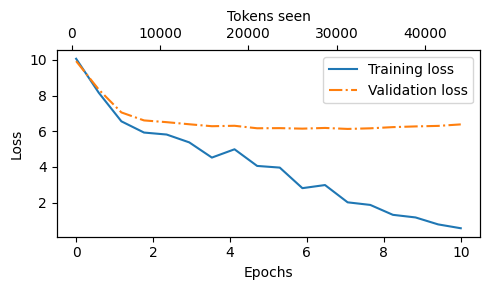

In [52]:
import matplotlib.pyplot as plt

def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(
        epochs_seen, val_losses, linestyle="-.", label="Validation loss"
    )
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax2 = ax1.twiny()
    ax2.plot(tokens_seen, train_losses, alpha=0)
    ax2.set_xlabel("Tokens seen")
    fig.tight_layout()
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [53]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 162,419,712


In [54]:
total_params_gpt2 = (
    total_params - sum(p.numel()
    for p in model.out_head.parameters())
)
print(f"Number of trainable parameters "
      f"considering weight tying: {total_params_gpt2:,}"
)

Number of trainable parameters considering weight tying: 123,822,336
